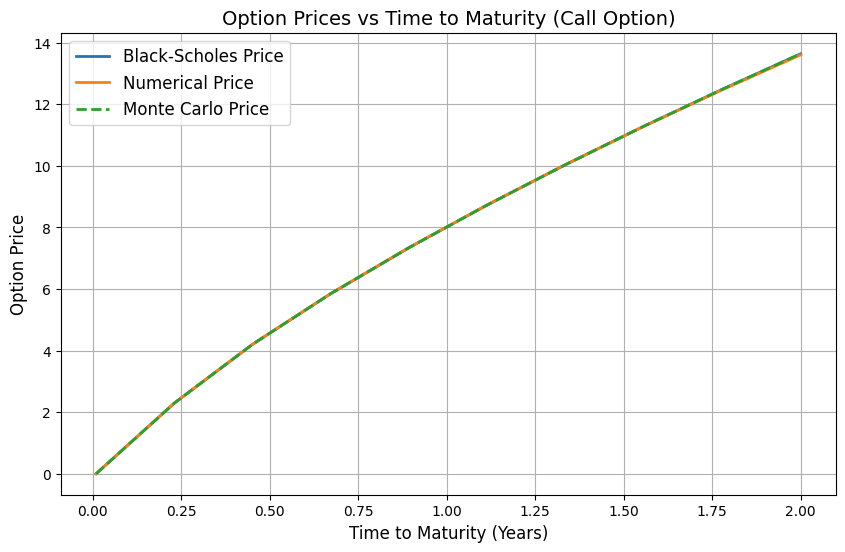

Numerical Option value: 8.027239
Black-Scholes Call Option Price: 8.021352
Monte Carlo Call Option Price: 8.022149 with error: 0.002342


In [14]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


def FiniteDifferenceMethodsEI(k, s0, r, q, T, sigma, s_min, s_max, M, N, option_type):
    """
    Approximates the value of a European option using the implicit finite difference method.

    Parameters:
        k (float): Strike price
        s0 (float): Initial stock price
        r (float): Risk-free interest rate
        q (float): Dividend yield
        T (float): Time to maturity
        sigma (float): Volatility
        s_min (float): Minimum stock price considered
        s_max (float): Maximum stock price considered
        M (int): Number of stock price intervals (M+1 points)
        N (int): Number of time intervals (N+1 points)
        option_type (str): 'C' for calls, 'P' for puts

    Returns:
        float: Approximate option value at S0 and T=0
    """
    # Step sizes
    dt = T / N
    dS = (s_max - s_min) / M

    # Coefficients for the tridiagonal matrix
    A = np.zeros(M - 1)
    B = np.zeros(M - 1)
    C = np.zeros(M - 1)

    for j in range(1, M):
        A[j - 1] = 0.5 * (r - q) * j * dt - 0.5 * (sigma**2) * (j**2) * dt
        B[j - 1] = 1 + (sigma**2) * (j**2) * dt + r * dt
        C[j - 1] = -0.5 * (r - q) * j * dt - 0.5 * (sigma**2) * (j**2) * dt

    # Boundary conditions and initial payoff
    D = np.zeros(M - 1)
    if option_type == 'call':  # Call option
        D[0] = max(0, s_min + dS - k)
        D[-1] = max(0, s_max - k) - C[-1] * max(0, s_max - k)
        for j in range(2, M - 1):
            D[j - 1] = max(s_min + j * dS - k, 0)
    elif option_type == 'put':  # Put option
        D[0] = max(k - s_min - dS, 0) - A[0] * k * np.exp(-r * dt)
        D[-1] = 0
        for j in range(2, M - 1):
            D[j - 1] = max(k - (s_min + j * dS), 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Forward substitution (Thomas algorithm) to initialize Cprime and Dprime
    Cprime = np.zeros_like(C)
    Dprime = np.zeros_like(D)

    Cprime[0] = C[0] / B[0]
    for i in range(1, M - 1):
        Cprime[i] = C[i] / (B[i] - A[i] * Cprime[i - 1])

    Dprime[0] = D[0] / B[0]
    for i in range(1, M - 1):
        Dprime[i] = (D[i] - A[i] * Dprime[i - 1]) / (B[i] - A[i] * Cprime[i - 1])

    # Backward substitution to solve
    solution = np.zeros_like(Dprime)
    solution[-1] = Dprime[-1]
    for i in range(M - 3, -1, -1):
        solution[i] = Dprime[i] - Cprime[i] * solution[i + 1]

    # Initialize solution matrix for N time steps
    price_matrix = np.zeros((M - 1, N + 1))
    price_matrix[:, -1] = solution

    # Time-stepping loop
    for t in range(N - 1, -1, -1):
        for j in range(1, M - 2):
            D[j] = price_matrix[j, t + 1]

        # Update boundary conditions
        if option_type == 'call':
            D[0] = price_matrix[0, t + 1]
            D[-1] = max(0, s_max - k) - C[-1] * max(0, s_max - k)
        else:
            D[0] = price_matrix[0, t + 1] - A[0] * k * np.exp(-r * (T - (T - 1 - t) * dt))
            D[-1] = 0

        # Recompute Dprime for the current time step
        Dprime[0] = D[0] / B[0]
        for i in range(1, M - 1):
            Dprime[i] = (D[i] - A[i] * Dprime[i - 1]) / (B[i] - A[i] * Cprime[i - 1])

        # Solve for F using backward substitution
        solution[-1] = Dprime[-1]
        for i in range(M - 3, -1, -1):
            solution[i] = Dprime[i] - Cprime[i] * solution[i + 1]

        # Store solution for the current time step
        price_matrix[:, t] = solution

    # Interpolation for S0
    for j in range(M):
        if abs(s0 - (s_min + j * dS)) <= 1e-6:
            return price_matrix[j, 0]

    raise ValueError("S0 is not a partition point of the grid. Check the parameters.")

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Calculate the Black-Scholes price for a European option.

    Parameters:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity (in years)
        r (float): Risk-free interest rate (annualized)
        sigma (float): Volatility of the stock (annualized)
        option_type (str): "call" for call option, "put" for put option

    Returns:
        float: Option price based on Black-Scholes formula
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def monte_carlo_option_pricing_antithetic(S, K, T, r, sigma, option_type="call", num_simulations=100000):
    """
    Calculate the option price using the Monte Carlo simulation with the antithetic variable technique.

    Parameters:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity (in years)
        r (float): Risk-free interest rate (annualized)
        sigma (float): Volatility of the stock (annualized)
        option_type (str): "call" for call option, "put" for put option
        num_simulations (int): Number of simulation trials (pairs of values)

    Returns:
        tuple: Option price based on Monte Carlo simulation,
               Standard error of the estimate.
    """
    np.random.seed(42)  # For reproducibility
    
    # Generate random samples
    Z = np.random.standard_normal(num_simulations)
    Z_antithetic = -Z  # Antithetic samples (negative of Z)
    
    # Simulate terminal stock prices for both sets of samples
    ST1 = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    ST2 = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_antithetic)
    
    # Calculate payoffs
    if option_type == "call":
        payoffs1 = np.maximum(ST1 - K, 0)
        payoffs2 = np.maximum(ST2 - K, 0)
    elif option_type == "put":
        payoffs1 = np.maximum(K - ST1, 0)
        payoffs2 = np.maximum(K - ST2, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    # Calculate the average of the paired payoffs (antithetic technique)
    payoffs_avg = 0.5 * (payoffs1 + payoffs2)
    
    # Discount to present value
    discounted_payoffs = np.exp(-r * T) * payoffs_avg
    
    # Estimate the option price
    option_price = np.mean(discounted_payoffs)
    
    # Calculate the standard error
    std_dev = np.std(discounted_payoffs, ddof=1)  # Sample standard deviation
    standard_error = std_dev / np.sqrt(num_simulations)
    
    return option_price, standard_error

if __name__ == "__main__":
    # Option parameters
    k = 105       # Strike price
    s0 = 100      # Initial stock price
    r = 0.05      # Risk-free rate
    q = 0.00      # Dividend yield
    T = 1         # Time to maturity
    sigma = 0.2   # Volatility
    s_min = 0     # Minimum stock price
    s_max = 200   # Maximum stock price
    M = 100000       # Stock price intervals
    N = 1000        # Time intervals
    option_type = "call"  # Option type: "call" or "put"

    # Time to maturity values
    times_to_maturity = np.linspace(0.01, 2, 10)  # From 0.01 to 2 years

    # Calculate option prices for each time to maturity
    bs_prices = []
    mc_prices = []
    nm_prices = []
    for T in times_to_maturity:
        bs_prices.append(black_scholes(s0, k, T, r, sigma, option_type))
        mc_prices.append(monte_carlo_option_pricing_antithetic(s0, k, T, r, sigma, option_type="call", num_simulations=10000000))
        nm_prices.append(FiniteDifferenceMethodsEI(k, s0, r, q, T, sigma, s_min, s_max, M, N, option_type))

    mc_price = [x[0] for x in mc_prices]

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(times_to_maturity, bs_prices, label="Black-Scholes Price", linewidth=2)
    plt.plot(times_to_maturity, nm_prices, label="Numerical Price", linewidth=2)
    plt.plot(times_to_maturity, mc_price, label="Monte Carlo Price", linestyle="--", linewidth=2)
    plt.title(f"Option Prices vs Time to Maturity ({option_type.capitalize()} Option)", fontsize=14)
    plt.xlabel("Time to Maturity (Years)", fontsize=12)
    plt.ylabel("Option Price", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Single calculation for demonstration
    T = 1  # Time to maturity (1 year)
    bs_price = black_scholes(s0, k, T, r, sigma, option_type)
    mc_price, mc_error = monte_carlo_option_pricing_antithetic(s0, k, T, r, sigma, option_type="call", num_simulations=10000000)
    value = FiniteDifferenceMethodsEI(k, s0, r, q, T, sigma, s_min, s_max, M, N, option_type)

    print(f"Numerical Option value: {value:.6f}")
    print(f"Black-Scholes {option_type.capitalize()} Option Price: {bs_price:.6f}")
    print(f"Monte Carlo {option_type.capitalize()} Option Price: {mc_price:.6f} with error: {mc_error:.6f}")


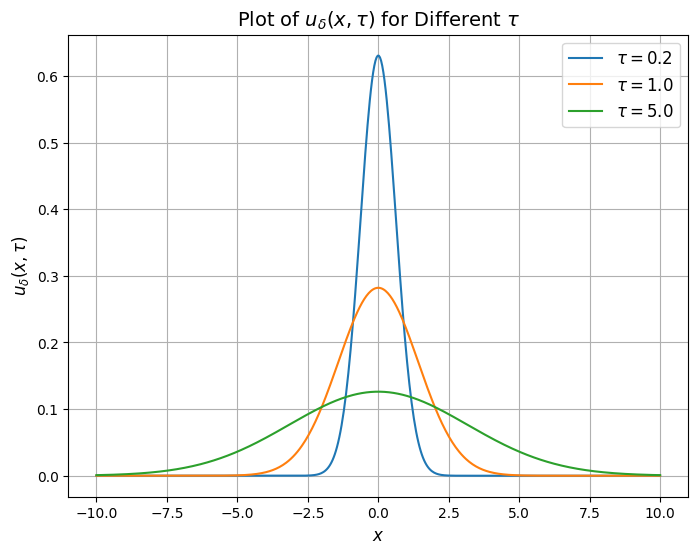

In [8]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def u_delta(x, tau):
    return (1 / (2 * np.sqrt(np.pi * tau))) * np.exp(-x**2 / (4 * tau))

# Define the x range and values of tau
x = np.linspace(-10, 10, 500)
taus = [0.2, 1.0, 5.0]

# Plot the function for each value of tau
plt.figure(figsize=(8, 6))
for tau in taus:
    plt.plot(x, u_delta(x, tau), label=f"$\\tau = {tau}$")

# Add labels, legend, and grid
plt.title("Plot of $u_\\delta(x, \\tau)$ for Different $\\tau$", fontsize=14)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$u_\\delta(x, \\tau)$", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()